# Classification Experiments

## Load libraries

In [595]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split,ShuffleSplit,learning_curve,KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import copy
plt.rcParams['figure.figsize'] = [12, 10]
size_set = "small"
pd.set_option('precision', 4)
pd.options.mode.use_inf_as_na = True
goal_metrics = ['f1']


In [498]:
classifiers = train_classifiers(X_train[:,0:97],y_train)
report_classifiers(classifiers,X_test,y_test,thing,1)

HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
STEP IN PIPELINE:  scale
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Load feature sets and get them ready

Here we load the features that we created in the preprocessing and feature extraction notebook. The schema of this file is the following: ADD SCHEMA

In [724]:
X_train, X_test, y_train, y_test = None,None,None,None
if(size_set == "small"):   
    dataset= "feature_set_small.csv"
    feature = "labels_set_small.csv"  
else:
    dataset = "feature_set_large.csv"
    feature = "labels_set_large.csv"

data = pd.read_csv(dataset).fillna(0)
labels = pd.read_csv(feature)
X_train, X_test, y_train, y_test = train_test_split(data.values, labels.values[:,0], test_size=0.25)
names = list(data)
ratio = float(np.sum(y_train == 'no-clickbait')) / np.sum(y_train == 'clickbait')
classifier_names = ["AdaBoost","XGBoost","Naive Bayes", "KNN"]

In [783]:
X_test

array([[2.01600000e+03, 6.09079439e+17, 9.00000000e+00, ...,
        9.16324386e-01, 7.03102134e-01, 0.00000000e+00],
       [1.26400000e+03, 6.09935186e+17, 6.60000000e+01, ...,
        1.00000000e+00, 8.61285668e-01, 0.00000000e+00],
       [1.75000000e+02, 6.08365726e+17, 7.30000000e+01, ...,
        6.44805116e-01, 7.60151032e-01, 4.91973680e-01],
       ...,
       [1.06600000e+03, 6.09888859e+17, 7.90000000e+01, ...,
        8.27623542e-01, 7.75745971e-01, 6.00597101e-01],
       [1.68000000e+03, 6.09508859e+17, 3.00000000e+01, ...,
        8.80061442e-01, 6.09443783e-01, 0.00000000e+00],
       [2.16500000e+03, 6.09556314e+17, 4.70000000e+01, ...,
        1.00000000e+00, 7.96602916e-01, 5.63642509e-01]])

In [459]:
np.sum(y_train == 'clickbait')/y_train.shape[0]

print("Original distribution of classes: ",float(np.sum(labels.values[:,0] == 'no-clickbait')) / np.sum(labels.values[:,0] == 'clickbait'))
print("Train distribution of classes: ",float(np.sum(y_train == 'no-clickbait')) / np.sum(y_train == 'clickbait'))
print("Test distribution of classes: ",float(np.sum(y_test == 'no-clickbait')) / np.sum(y_test == 'clickbait'))

Original distribution of classes:  2.227034120734908
Train distribution of classes:  2.28698752228164
Test distribution of classes:  2.0597014925373136


In [472]:
p_original = np.sum(labels.values[:,0] == 'clickbait')/np.sum(labels.values[:,0].shape[0])
p_train = np.sum(y_train == 'clickbait')/y_train.shape[0]
p_test = np.sum(y_test == 'clickbait')/y_test.shape[0]
me_train = 1.96*np.sqrt((p_train*(1-p_train))/y_train.shape[0])
me_test = 1.96*np.sqrt((p_test*(1-p_test))/y_test.shape[0])
print("Original clickbait proportion: ", str(p_original))                                                           
print("Train set Confidence interval",'( '+str(p_train+me_train),str(p_train-me_train)+' )')
print("Test set Confidence interval",'( '+str(p_test+me_test),str(p_test-me_test)+' )')

Original clickbait proportion:  0.3098820658804392
Train set Confidence interval ( 0.32522945914077334 0.2832304107073828 )
Test set Confidence interval ( 0.3639008910412912 0.2897576455440747 )


In [478]:
ztr = (p_train - p_original)/np.sqrt((p_original*(1-p_original))/y_train.shape[0])
zt = (p_test - p_original)/np.sqrt((p_original*(1-p_original))/y_test.shape[0])
print(ztr)
print(zt)

-0.524847092759644
0.9088154392538469


## Processing section

In [167]:
def scaling_features(X_train,X_test,type_scale="standard"):
    train,test = None,None
    if(type_scale == "standard"):
        scaler = StandardScaler()
        train =  copy.deepcopy(scaler.fit_transform(X_train))
        test = copy.deepcopy(scaler.transform(X_test))
    else:
        scaler = MinMaxScaler()
        train = copy.deepcopy(scaler.fit_transform(X_train))
        test = copy.deepcopy(scaler.transform(X_test))
    return [train,test]

In [168]:
print(names[0],names[32])

np.argwhere(a.get_support()).flatten()

Unnamed: 0 featRatioCharTargetDescription_TargetKeywords


array([ 0, 32])

## Feature Ranking

In [149]:
feature_importance = list(zip(names,mutual_info_classif(X_train,y_train)))
feature_importance_table = pd.DataFrame(feature_importance,columns=["feature","importance"]) 
feature_importance_table = feature_importance_table.sort_values("importance",ascending=False)
feature_importance_table['index'] = range(1, len(feature_importance_table) + 1)

In [505]:
print(feature_importance_table.loc[feature_importance_table['index'] <= 70].to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                         feature &  importance &  index \\
\midrule
 featRatioCharTargetDescription\_TargetParagraphs &      0.0389 &      1 \\
                                featCountPOS\_WRB &      0.0387 &      2 \\
                                featCountPOS\_NNP &      0.0386 &      3 \\
   featRatioCharTargetDescription\_TargetKeywords &      0.0383 &      4 \\
                         featCountPOS\_WRB\_NNS\_RB &      0.0374 &      5 \\
            featRatioCharPostText\_TargetKeywords &      0.0329 &      6 \\
                           featCountPOS\_DT\_JJ\_RB &      0.0310 &      7 \\
                             featCountPOS\_NNP\_NN &      0.0296 &      8 \\
                         featCountPOS\_RB\_VBZ\_NNP &      0.0281 &      9 \\
                          featCountPOS\_NN\_IN\_NNP &      0.0279 &     10 \\
         featRatioCharPostText\_TargetDescription &      0.0278 &     11 \\
                    featNumCharTargetDesc

In [182]:
def get_selector(X,y,number_feat):
    return SelectKBest(mutual_info_classif, k=number_feat).fit(X, y)

In [189]:
def get_feature_curves(X_train,y_train,X_test,y_test,n):
    performances = np.zeros((4,X_train.shape[1]))
    for i in range(n):   
        selector = get_selector(X_train,y_train,i+1)
        np.argwhere(selector.get_support()).flatten()
        X_new_train = selector.transform(X_train)
        print("SHAPE SELECTED FEATURES",X_new_train.shape)
        classifiers = train_classifiers(X_new_train,y_train)
        X_new_test = selector.transform(X_test)
        for enum, classifier in enumerate(classifiers):
            y_true, y_pred = y_test, classifier.predict(X_new_test)
            performances[enum,i] = f1_score(y_true, y_pred, average='weighted')    
    return performances;
        

## Definition of classifiers

In [174]:
def best_params(classifier,param_grid,X,y):
    print(type(classifier).__name__,thing)
    for score in goal_metrics:
        print("# Tuning hyper-parameters for %s" %score)
        print()

        clf = GridSearchCV(classifier, param_grid, cv=5,
                           scoring='%s_macro' % score)
        clf.fit(X, y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #    print("%0.3f (+/-%0.03f) for %r"
        #          % (mean, std * 2, params))
        print()

        return clf.best_estimator_

In [175]:
grid_adaboost = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best"],
                  "base_estimator__class_weight": ["balanced",None],
                  "n_estimators": [10,20,30,40,50]
                 }

grid_xgboost = { 
              'objective':['binary:logistic'],
              'learning_rate': [0.2], 
              'max_depth': [5,6,7],
              'booster': ['gbtree'],
              'n_estimators': [20,30,40],
              'scale_pos_weight':[1,ratio, 1/ratio]}
grid_knn = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}

#best adaboost 
#{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 30}
#best xgboost
#{'booster': 'gbtree', 'lambda': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.4623314829500396}

In [496]:
def classification_report(thing_tried,classifier, X_test,y_test,initial):
        print("STEP IN PIPELINE: ",thing_tried)
        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        if(initial==1):
            y_true, y_pred = y_test, classifier.predict(X_test[:,0:97])
        else:
            y_true, y_pred = y_test, classifier.predict(X_test)
        print("Classification report for classifier %s:\n%s\n"
        % (classifier, metrics.classification_report(y_true, y_pred)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))
        print("--------------------------")
        return [y_true, y_pred]

In [497]:
def report_classifiers(classifiers,X_test,y_test,step,initial):
    for c in classifiers:
        classification_report(step,c,X_test,y_test,initial)

## Classification

In [178]:
def train_classifiers(X_train,y_train):
    print("HYPER PARAMETER TUNING  *********************")
    adaboost_c = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,))
    xgb_c = xgb.XGBClassifier()
    gnb_c = GaussianNB()
    knn_c = KNeighborsClassifier()
    
    adaboost_c = best_params(adaboost_c,grid_adaboost,X_train,y_train)
    xgb_c = best_params(xgb_c,grid_xgboost,X_train,y_train)   
    gnb_c.fit(X_train,y_train)
    knn_c = best_params(knn_c,grid_knn,X_train,y_train)
    classifiers =[adaboost_c,xgb_c,gnb_c,knn_c]
    print("END HYPERPARAMETER TUNING  *********************")

    return classifiers

In [163]:
#things_try = ['normal','scale','feture_selection','feature_extraction','threshold']
things_try = ['normal','scale']

for thing in things_try:
    if(thing=="original"):
        classifiers = train_classifiers(X_train[:,0:97],y_train)
        report_classifiers(classifiers,X_test,y_test,thing)
        
    if(thing == 'normal'):    
        classifiers = train_classifiers(X_train,y_train)
        report_classifiers(classifiers,X_test,y_test,thing)
    if(thing == 'scale'):
        type_scale = "standard"
        [new_xtrain,new_xtest] = scaling_features(X_train,X_test,"standard")
        classifiers = train_classifiers(new_xtrain,y_train)
        report_classifiers(classifiers,new_xtest,y_test,thing+str(type_scale))
        
        type_scale = "minmax"
        [new_xtrain,new_xtest] = scaling_features(X_train,X_test,type_scale)
        classifiers = train_classifiers(new_xtrain,y_train)
        report_classifiers(classifiers,new_xtest,y_test,thing+str(type_scale))
    if(thing=="feture_selection"):
        #number of featrues to check
        n=45
        type_scale = "minmax"
        [new_xtrain,new_xtest] = scaling_features(X_train,X_test,type_scale)
        classifiers = train_classifiers(new_xtrain,y_train)
        get_feature_curves(classifiers, new_xtrain,y_train,new_xtest,y_test,n)
        
        

AdaBoostClassifier normal
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier normal
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.42945736434108533}

Grid scores on development set:


KNeighborsClassifier normal
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


normal
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 10}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.42945736434108533}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


scalestandard
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassi

### Compare our features with theirs

(615, 502)

## Feature curves

In [727]:
#number of featrues to check
n=160
type_scale = "standard"
[new_xtrain,new_xtest] = scaling_features(X_train,X_test,type_scale)
performance = get_feature_curves(new_xtrain,y_train,new_xtest,y_test,n)

SHAPE SELECTED FEATURES (1844, 1)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:114

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SHAPE SELECTED FEATURES (1844, 2)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 30}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 3)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SHAPE SELECTED FEATURES (1844, 9)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 10)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Bes

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SHAPE SELECTED FEATURES (1844, 12)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 20}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 13)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best par

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 22)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  **********

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SHAPE SELECTED FEATURES (1844, 24)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 20}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 25)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

B

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SHAPE SELECTED FEATURES (1844, 29)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 10}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 30)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1


Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 39)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  **********

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 49)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 10}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 30, 'objective'

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 59)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'entropy', 'base_estimator__split

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 68)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 30}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  ***********

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 78)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'bina

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 88)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__sp

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 97)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  ********************

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 20, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 107)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': 'bin

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 20}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 117)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__spli

Best parameters set found on development set:

{'n_neighbors': 10}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 126)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 20}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 136)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'objective': '

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 8}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 146)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': 'balanced', 'base_estimator__criterion': 'entropy', 'base_estimator

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
SHAPE SELECTED FEATURES (1844, 155)
HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 30}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


END HYPERPARAMETER TUNING  *******************

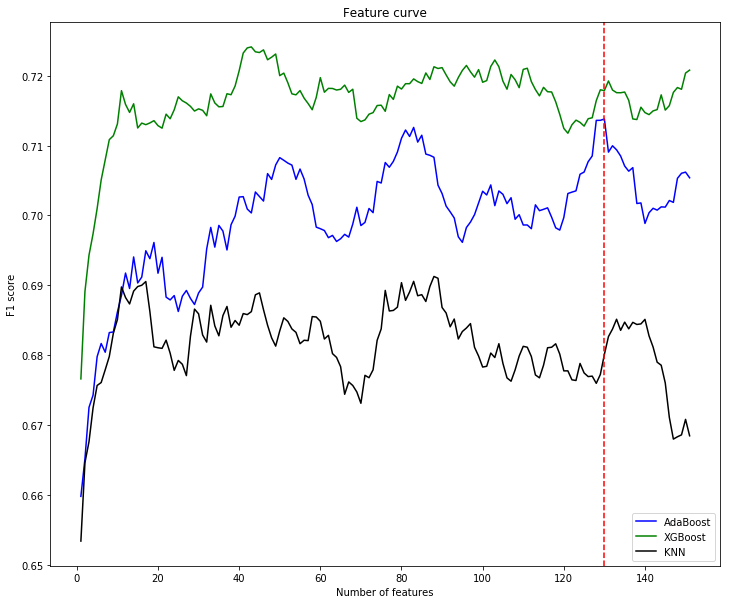

In [860]:
n=160
x_axis = np.arange(n) +1
plt.plot(x_axis,performance[0,0:n],'-b') 
plt.plot(x_axis,performance[1,0:n],'-g') 
plt.plot(x_axis,performance[3,0:n],'-k') 

plt.axvline(x=158,color='r',linestyle='--')
plt.xlabel("Number of features")
plt.ylabel("F1 score")
plt.show()

In [875]:
print("Adaboost: " + str(avada[130]+0.02) +" XGBoost: " + str(avxg[130]+0.022)+" KNN: " + str(avknn[130]+0.013))

Adaboost: 0.7090564732286251 XGBoost: 0.7212225031094208 KNN: 0.6806992879141267


In [517]:
pd.DataFrame({'adaboost':avada,'XGBoost':avxg,'Naive':avnaive,'KNN':avknn}).to_csv('feature_curves.csv')

In [868]:
np.argmax(performance[:,0:n],axis=1)

array([82, 67, 88, 88])

In [871]:
performance[1,67]

0.7232659633306341

In [872]:
n=502
x_train_n = get_selector(new_xtrain,y_train,n).transform(new_xtrain)
x_test_n = get_selector(new_xtrain,y_train,n).transform(new_xtest)

classifiers = train_classifiers(x_train_n,y_train)
report_classifiers(classifiers,x_test_n,y_test,"PCA",0)

HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'n_estimators': 50}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 30, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 6}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************
STEP IN PIPELINE:  PCA
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report fo

## Dimensionality Reduction

In [759]:
pca = PCA(n_components = 502)

In [764]:
pca.fit(new_xtrain)
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var[208] #cumulative sum of variance explained with [n] features

90.80000000000007

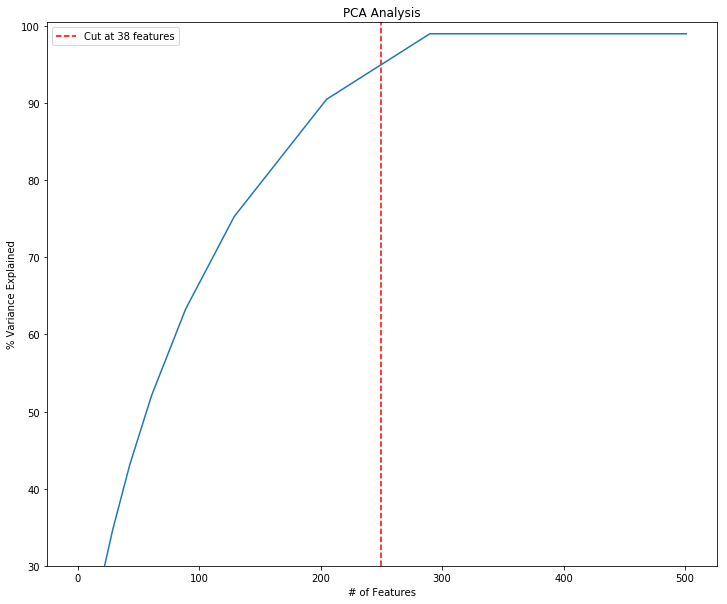

In [772]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.axvline(x=250,color='r',linestyle='--',label="Cut at 38 features")
plt.legend()

plt.plot(var)

In [886]:
pca = PCA(n_components = 250)
pca.fit(new_xtrain)
pca_x_train = pca.transform(new_xtrain)
pca_x_test = pca.transform(new_xtest)

In [887]:
pca_x_train.shape

(1844, 250)

In [888]:
classifiers = train_classifiers(pca_x_train,y_train)

HYPER PARAMETER TUNING  *********************
AdaBoostClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'base_estimator__class_weight': None, 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 40}

Grid scores on development set:


XGBClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 40, 'objective': 'binary:logistic', 'scale_pos_weight': 0.430566330488751}

Grid scores on development set:


KNeighborsClassifier scale
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:


END HYPERPARAMETER TUNING  *********************


In [889]:
report_classifiers(classifiers,pca_x_test,y_test,"PCA",0)

STEP IN PIPELINE:  PCA
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=40, random_state=None):
              precision    recall  f1-score   support

   clickbait       0.53      0.32      0.40       192
no-clickbait       0.74      0.87      0.80       423

   micro avg       0.70      0.70      0.70       615
   macro avg       0.63      0.60      0.60       615
weighted avg       0.67      0.70      0.67       

## Getting bad samples

In [815]:
y_true_error,y_pred_error = classification_report("ERROR ANALYSOS",classifiers[1],pca_x_test,y_test,0)

STEP IN PIPELINE:  ERROR ANALYSOS
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.430566330488751,
       seed=None, silent=True, subsample=1):
              precision    recall  f1-score   support

   clickbait       0.57      0.37      0.45       192
no-clickbait       0.75      0.87      0.81       423

   micro avg       0.72      0.72      0.72       615
   macro avg       0.66      0.62      0.63       615
weighted avg       0.70      0.72      0.70       615


Confusion matrix:
[[ 71 121]
 [ 54 369]]
--------------------

In [820]:
mismatches = (y_true_error != y_pred_error)

In [833]:
ids = np.argwhere(mismatches == True).flatten()

In [855]:
X_test[ids,:]
y_pred_error[ids]

array(['no-clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'no-clickbait', 'no-clickbait', 'clickbait', 'clickbait',
       'no-clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'no-clickbait', 'no-clickbait', 'clickbait', 'no-clickbait',
       'no-clickbait', 'no-clickbait', 'clickbait', 'clickbait',
       'clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'no-clickbait', 'no-clickbait', 'clickbait', 'no-clickbait',
       'clickbait', 'no-clickbait', 'no-clickbait', 'no-clickbait',
       'no-clickbait', 'no-clickbait', 'clickbait', 'clickbait',
       'no-clickbait', 'clickbait', 'no-clickbait', 'no-clickbait',
       'clickbait', 'no-clickbait', 'no-clickbait', 'clickbait',
       'no-clickbait', 'no-clickbait', 'no-clickbait',

In [856]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
errors = pd.DataFrame(data=X_test[ids,:],columns=names)
errors['predicted_label'] = y_pred_error[ids]
errors.to_csv('errors_made.csv')

In [857]:
errors

,Unnamed: 0,id,featNumCharPostText,featNumCharTargetTitle,featNumCharTargetDescription,featNumCharTargetKeywords,featNumCharTargetCaptions,featNumCharTargetParagraphs,featDiffCharPostText_TargetCaptions,featDiffCharPostText_TargetDescription,...,featCountPOS_WRB_NNP_NNS,featCountPOS_WRB_NNP_VBZ,featCountPOS_WRB_RB_NN,featCountPOS_WRB_VBZ_NNS,featIsNEPresent,featSentiment,featSimilarityPostTextTargetTitle,featSimilarityPostTextTargetParagraphs,featSimilarityPostTextTargetKeywords,predicted_label
0,175.00,608365725540085760.00,73.00,38.00,63.00,92.00,50.00,7144.00,23.00,10.00,...,0.00,0.00,0.00,0.00,0.00,0.25,0.64,0.76,0.49,no-clickbait
1,749.00,610133346635657216.00,51.00,25.00,98.00,46.00,6905.00,2437.00,6854.00,47.00,...,0.00,0.00,0.00,0.00,1.00,-0.30,0.85,0.87,0.82,no-clickbait
2,1166.00,608257995458420736.00,73.00,59.00,86.00,88.00,1517.00,2331.00,1444.00,13.00,...,0.00,0.00,0.00,0.00,1.00,-0.40,0.94,0.86,0.42,no-clickbait
3,1427.00,607715038426624000.00,66.00,55.00,117.00,266.00,1942.00,401.00,1876.00,51.00,...,0.00,0.00,0.00,0.00,1.00,0.32,0.99,0.77,0.69,no-clickbait
4,1225.00,608850005366087680.00,78.00,56.00,68.00,107.00,307.00,0.00,229.00,10.00,...,0.00,0.00,0.00,0.00,1.00,-0.76,0.88,0.00,0.74,no-clickbait
5,309.00,607996802080501760.00,75.00,63.00,141.00,3.00,18.00,1879.00,57.00,66.00,...,0.00,0.00,0.00,0.00,1.00,0.54,0.68,0.89,0.25,no-clickbait
6,1697.00,607701474559332352.00,55.00,26.00,0.00,0.00,0.00,40.00,55.00,55.00,...,0.00,0.00,0.00,0.00,1.00,-0.32,0.46,0.46,0.00,clickbait
7,68.00,608749345731674112.00,32.00,52.00,93.00,0.00,0.00,1310.00,32.00,61.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.86,0.79,0.00,clickbait
8,2293.00,609344544522522624.00,43.00,70.00,112.00,62.00,0.00,1515.00,43.00,69.00,...,0.00,0.00,0.00,0.00,1.00,-0.35,0.93,0.90,0.68,no-clickbait
9,1466.00,609391764433162240.00,83.00,75.00,90.00,142.00,127.00,4047.00,44.00,7.00,...,0.00,0.00,0.00,0.00,1.00,-0.64,0.73,0.79,0.70,no-clickbait


In [876]:
names

['Unnamed: 0',
 'id',
 'featNumCharPostText',
 'featNumCharTargetTitle',
 'featNumCharTargetDescription',
 'featNumCharTargetKeywords',
 'featNumCharTargetCaptions',
 'featNumCharTargetParagraphs',
 'featDiffCharPostText_TargetCaptions',
 'featDiffCharPostText_TargetDescription',
 'featDiffCharPostText_TargetKeywords',
 'featDiffCharPostText_TargetParagraphs',
 'featDiffCharPostText_TargetTitle',
 'featDiffCharTargetCaptions_TargetDescription',
 'featDiffCharTargetCaptions_TargetKeywords',
 'featDiffCharTargetCaptions_TargetParagraphs',
 'featDiffCharTargetCaptions_TargetTitle',
 'featDiffCharTargetDescription_TargetKeywords',
 'featDiffCharTargetDescription_TargetParagraphs',
 'featDiffCharTargetDescription_TargetTitle',
 'featDiffCharTargetKeywords_TargetParagraphs',
 'featDiffCharTargetKeywords_TargetTitle',
 'featDiffCharTargetParagraphs_TargetTitle',
 'featRatioCharPostText_TargetCaptions',
 'featRatioCharPostText_TargetDescription',
 'featRatioCharPostText_TargetKeywords',
 'feat

## Generalization

In [976]:
X_train_large, X_test_large, y_train_large, y_test_large = None,None,None,None
names = list(data)
names_large = list(data_large)
not_in = list(set(names) ^ set(names_large))
size_set = "large"
if(size_set == "small"):   
    dataset= "feature_set_small.csv"
    feature = "labels_set_small.csv"  
else:
    dataset = "feature_set_large.csv"
    feature = "labels_set_large.csv"

data_large = pd.read_csv(dataset).fillna(0)
data_large = data_large[data_large.columns.intersection(names)]
data_large = pd.concat([data_large,pd.DataFrame(0,index=np.arange(len(data_large)),columns=list(not_in))],axis=1)

labels_large = pd.read_csv(feature)
labels_large = labels_large[['truthClass','truthMean']]
X_test_large, y_test_large = data_large.values, labels_large.values[:,0]

ratio = float(np.sum(y_test_large == 'no-clickbait')) / np.sum(y_test_large == 'clickbait')
classifier_names = ["AdaBoost","XGBoost","Naive Bayes", "KNN"]

In [977]:
data_large.isnull()

,Unnamed: 0,id,featNumCharPostText,featNumCharTargetTitle,featNumCharTargetDescription,featNumCharTargetKeywords,featNumCharTargetCaptions,featNumCharTargetParagraphs,featDiffCharPostText_TargetCaptions,featDiffCharPostText_TargetDescription,...,featCountPOS_NNS_NNP_WP,featCountPOS_NNP_WP_JJ,featCountPOS_PRP_JJ_NNP,featCountPOS_WRB_RB_NN,featCountPOS_VBZ_WRB_NNS,featCountPOS_VBZ_RB_IN,featCountPOS_NN_WRB_VBZ,featCountPOS_NNP_VBZ_WRB,featCountPOS_RB_VBZ_WP,featCountPOS_PRP_IN_NNS
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [978]:
[new_xtrain,new_xtest_large] = scaling_features(X_train,X_test_large,"standard")
pca = PCA(n_components = 250)
pca.fit(new_xtrain)
pca_x_train = pca.transform(new_xtrain)
pca_x_test = pca.transform(new_xtest_large)

In [980]:
report_classifiers(classifiers,pca_x_test,y_test_large,"PCA",0)

STEP IN PIPELINE:  PCA
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=40, random_state=None):
              precision    recall  f1-score   support

   clickbait       0.26      0.01      0.01      4761
no-clickbait       0.76      0.99      0.86     14777

   micro avg       0.75      0.75      0.75     19538
   macro avg       0.51      0.50      0.44     19538
weighted avg       0.64      0.75      0.65     19

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

   clickbait       0.24      1.00      0.39      4761
no-clickbait       0.00      0.00      0.00     14777

   micro avg       0.24      0.24      0.24     19538
   macro avg       0.12      0.50      0.20     19538
weighted avg       0.06      0.24      0.10     19538


Confusion matrix:
[[ 4761     0]
 [14777     0]]
--------------------------
STEP IN PIPELINE:  PCA
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

   clickbait       0.24      0.99      0.39      4761
no-clickbait       0.72      0.01      0